In [1]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [2]:
features = 64
# define a simple linear VAE #until now normal VAE without Beta
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder 84*84 = 7’056
        self.enc0 = nn.Linear(in_features=84*84, out_features=1024)
        self.enc1 = nn.Linear(in_features=1024, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec0 = nn.Linear(in_features=features, out_features=512)
        self.dec1 = nn.Linear(in_features=512, out_features=1024)
        self.dec2 = nn.Linear(in_features=1024, out_features=84*84)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    
    def encode(self, x):
        x = F.relu(self.enc0(x))
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

In [3]:
train_data = numpy.load('train_data100kFEB23.npy')
val_data = numpy.load('val_data20kFEB23.npy')

In [4]:
print(train_data.shape)

(101848, 84, 84)


In [5]:
BVAE = LinearVAE()
BVAE.load_state_dict(torch.load('C:/Users/erics/Documents/Programme/Bachelorarbeit/models/BVAE_Pong/B=10VAEFEB25'))
BVAE.to(device)

LinearVAE(
  (enc0): Linear(in_features=7056, out_features=1024, bias=True)
  (enc1): Linear(in_features=1024, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=128, bias=True)
  (dec0): Linear(in_features=64, out_features=512, bias=True)
  (dec1): Linear(in_features=512, out_features=1024, bias=True)
  (dec2): Linear(in_features=1024, out_features=7056, bias=True)
)

In [6]:
randomInput = torch.rand(256, 7056, device=device) #7056 = 84* 84
print(randomInput)


tensor([[0.9477, 0.2006, 0.3367,  ..., 0.3414, 0.5578, 0.8409],
        [0.8019, 0.5284, 0.9396,  ..., 0.7768, 0.2728, 0.3317],
        [0.1063, 0.2328, 0.8886,  ..., 0.4311, 0.3340, 0.9872],
        ...,
        [0.1354, 0.9342, 0.3461,  ..., 0.7457, 0.3368, 0.2063],
        [0.8481, 0.1277, 0.9694,  ..., 0.9112, 0.6593, 0.1405],
        [0.2062, 0.8119, 0.2687,  ..., 0.9942, 0.0456, 0.9232]],
       device='cuda:0')


In [7]:
enco = BVAE.encode(randomInput)
print(enco)

tensor([[-7.2475e-02, -3.5465e-02, -1.7795e-03,  ..., -1.2069e-03,
         -3.5131e+00, -9.7398e+00],
        [-4.6631e-02,  4.7407e-02,  1.1334e-03,  ..., -4.0724e-03,
         -5.1348e+00, -1.0074e+01],
        [ 2.6341e-03, -2.9040e-03, -1.5083e-02,  ...,  1.7403e-02,
         -4.7097e+00, -9.9245e+00],
        ...,
        [-3.6814e-02,  5.7286e-02, -5.5237e-02,  ..., -1.5174e-02,
         -4.5983e+00, -9.9934e+00],
        [-3.4460e-02,  7.6145e-03,  4.4472e-02,  ...,  1.1537e-02,
         -4.2551e+00, -9.6396e+00],
        [-2.6932e-04,  3.5962e-02, -4.2956e-02,  ..., -4.4615e-02,
         -5.2881e+00, -9.8813e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [24]:
def KLdiv(mu, logvar):
    print(mu.size())
    print((1 + logvar - mu.pow(2) - logvar.exp()).size())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD.size())
    return KLD

In [26]:
x = enco.view(-1, 2, features)
# get `mu` and `log_var`
mu = x[:, 0, :] # the first feature values as mean
log_var = x[:, 1, :]

KLenco = KLdiv(mu, log_var)
print(KLenco.size())

#TODO: Wie macht man dimensionwise KL-divergence??

torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([])
torch.Size([])


In [10]:
#enco = enco.detach().cpu().numpy()
KLencoNP = KLenco.detach().cpu().numpy()

In [11]:
print(KLencoNP.shape)

()


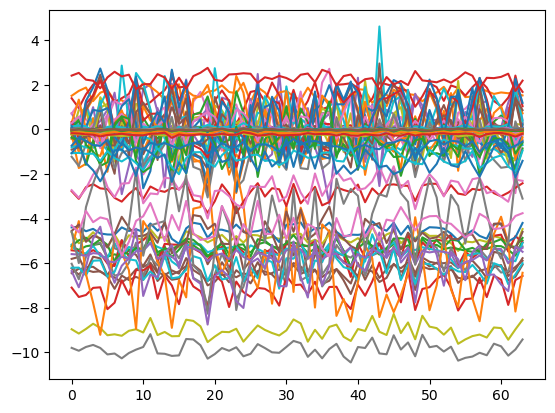

In [37]:
plt.plot(enco)
plt.show()

In [40]:
enco = numpy.mean(enco, axis=0)

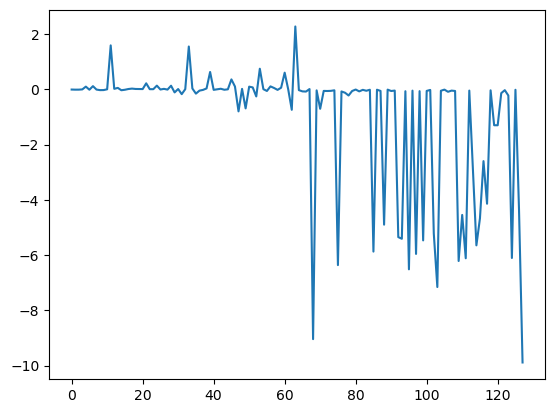

In [41]:
plt.plot(enco)
plt.show()

In [45]:
numZero = (numpy.histogram(enco, bins=(-0.5, 0.5))[0])/2 #/2 da logvar & mean
print(numZero)

[47.]


In [46]:
Nonzero = 64-numZero
print(Nonzero)

[17.]
